# STAT 131 final project: Music taste profile generator  <img src="https://www.iosicongallery.com/icons/spotify-music-2015-07-30/512.png" align="right" width="120" hspace="25"/>

> ### Simran Vatsa, Sohom Paul

#### *Using audio features from Spotify and our own musical preferences to gain insight into popular music, as well as ourselves.*

[video presentation](https://youtu.be/q_-gUsctluU) || [slides](https://goo.gl/nhQRfi)

Spotify is a music streaming platform, currently the most utilized such service in the world. Over this past summer, we discovered Spotify's web API and its associated documentation, and we were fascinated by how the service's data scientists quantify musical attributes for the songs it streams. They do so by defining new audio features for each track, in addition to recording some well-known ones. A full list of definitions for these features can be found [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

What excited us most is that it's possible for the general public to access this information, although they do have to get past a few technological barriers to do so efficiently. We like that Spotify revels in being transparent about data, and even sends a [little package of personalized data](https://spotifywrapped.com/) your way at the end of every year, unlike other [famously secretive](https://www.netflix.com/browse) tech giants in the content streaming business.

We're both music enthusiasts and amateur performers, so (we'd like to think) we understand music. Also, on a more anecdotal note, we went to high school together, where we headed the music department our senior year and performed together on quite a few occasions; so music is something we've often discussed, connected, agreed and disagreed on. So for this project, we decided to create a music taste profile generator, using ourselves as the music consumers to create profiles for. 

As aspiring data people, something we get told about a lot is the 80/20 trope; data scientists spend 80% of their time "finding, cleaning, and organizing data" and only 20% of it actually modeling. While [this may be changing](https://hbr.org/2018/08/what-data-scientists-really-do-according-to-35-data-scientists), we thought it might be truly illustrative of a real-life experience to start from scratch and build the dataset ourselves. It also seemed kind of fun, as well as an opportunity to learn how Python performs webscraping and interacts with APIs, both of which we've enjoyed exploring in R. It also gave us the chance to customize the data we used, unlike some of the music-related datasets we looked at on Kaggle.

It's possible for users to procure Spotify audio features for a track if they have its Spotify track ID, a 22-character unique alphanumeric code. To obtain these IDs, as well as a list of songs to mine features for, we used [spotifycharts.com](https://spotifycharts.com). You can download any daily or weekly Spotify Top 200 chart from the past two years as a .csv from this site. This .csv, in addition to track name, artist and number of streams that week/day, also contains the track ID we would need to query the API for audio features. 

We decided our dataset would contain **track names, artists and audio features for all songs that appeared on the Spotify weekly Global Top 200 in 2017**, as well as other features we saw fit to create using these.

A brief overview of our process:
* **Create a dataset containing songs and their audio features.** 
* **Code each song in the dataset with either 0/1 for dislike/like, respectively.** We did this individually and separately, so we have two sets of predictors. This way, we could use each other's tastes as predictors, since people tend to take algorithmic recommendations more seriously when they're compounded by endorsements from friends. Also, this involved listening to approximately 600 songs in a week, which was ... overwhelming, to say the least. While listening to songs, the only details we were given were song title and artist name. A limitation we saw immediately here was that we already knew some songs on this list, and were likely to feel differently about them than any song we'd just heard.
* **Explore the distributions of and relationships between the audio features.**
* **Explore the correlations between these features and our taste.** Since this is behavioral data, we aren't expecting very high accuracy in our predictive models; if anything, our models will likely prove the necessity for complicated algorithms, scary amounts of data and even an [annual ACM conference](https://recsys.acm.org/) devoted to building recommender systems. Taste is a slippery thing to quantify, after all.
* **Build a model to predict whether or not we will like a song.**
* **Discuss how our insights could be commercially applied in our presentation.** We pitch to Star Records Music Studio, a record label that is looking to use data-driven methods to boost the number of Spotify plays the artists signed to it get. As technical music consultants, we explain how our data, in combination with the user database we hope to build, of which we are the first two members, can help Star Records not only find its way to the Global Top 200 but also appeal to as many people as possible, or even target certain segments of listeners.
* [**Here's the link to our video presentation.**](https://youtu.be/q_-gUsctluU)


This next section deals more in detail with the data acquisition and cleaning process. We end it with a description of our final dataset.

## Data acquisition and cleaning

In [1]:
import csv
import numpy as np
import pandas as pd
import requests
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time

In [2]:
start_range = pd.date_range(pd.to_datetime("12/30/2016"), periods=52, freq='7D')
end_range = pd.date_range(pd.to_datetime("01/06/2017"), periods=52, freq='7D')

In [3]:
urlList = "https://spotifycharts.com/regional/global/weekly/" + pd.Series(start_range.format()) + "--" + pd.Series(end_range.format()) + "/download"

While exploring spotifycharts.com, we found that the chart URLs followed a standard format that incorporated the chart week's start and end dates, and that adding '/download' to any chart URL resulted in the URL for a direct download of the .csv. The variable `urlList` contains the URLs of all the charts we want to work with, which span the year 2017. 

In [ ]:
combined = pd.DataFrame()
for url in urlList:
    req = requests.get(url)
    text = req.text.split('\n')
    reader = csv.reader([row.replace('"', '|') for row in text], quotechar='|')
    df = pd.DataFrame()
    for row in reader:
        df = pd.concat([df, pd.DataFrame(row)], axis= 1)
    combined = combined.append(df.transpose().iloc[2:202,:], ignore_index = True)

We used the `requests` library's `get()` function to create a Response object `req`. Using the Response object's `.text` method, we obtained the .csv's text, which we split by the newline character. Splitting the text into columns proved harder than expected, since some songs and artists have commas in their names ("thank u, next", "Tyler, the Creator"). 

We found that any multi-word entry was encased in double quotes, so we adjusted the `csv` library's `reader()` parameters to accommodate for this. We then appended each individual chart to the dataframe `combined` as they were processed. We obtained a 10,120-row dataframe; we expected 10,400 (52 x 200) but two charts in July were inaccessible. That left us with 120 extra rows, so we decided to manually investigate.

In [ ]:
combined = combined.drop(combined.index[4200:4320])
combined.index = range(0, 10000, 1)
combined = combined.drop([0,5,6], axis = 1)
combined.columns = ["song", "artist", "plays", "track_url"]

Some manual exploration showed that rows 4200 to 4319 contained HTML, not chart entries. We dropped those from `combined`, and were left with the number of rows we expected. We also dropped extra columns and renamed the ones we retained.

In [ ]:
unique_songs = combined.drop_duplicates(subset = 'song')
unique_songs.index = range(0,865,1)
unique_songs = unique_songs.drop("plays", axis = 1)
unique_songs['track_id'] = unique_songs.track_url.str[31:]

To code songs 0/1, we needed to distill our dataset to unique songs only. We did this using song names; we tried using track ID, since we imagined that would give us better results, but it turns out these track IDs don't remain consistent, since the result of that contained multiple duplicates. (We haven't investigated that thoroughly, but our best guess is that IDs of singles change when they are re-released as part of an album.) 

We probably lost out on some Christmas music as a result of using song name (as is, we have three versions of "Santa Baby" toward the end of our dataset), but we decided it would be OK to cut some losses there.

In [ ]:
song_counts = pd.DataFrame(combined.song.value_counts()).reset_index()
song_counts.columns = ['song', 'song_count']
unique_songs = unique_songs.merge(song_counts, on='song')

In [ ]:
combined['plays'] = combined.plays.astype('int64')
plays = combined.groupby('song')['plays'].sum().to_frame().reset_index()
unique_songs = unique_songs.merge(plays, on= 'song')

We realized that we were losing potentially valuable information, such as **total number of streams while charting** and **number of times the song charted**, so we created these metrics from `combined`.

Since we have only a year's data, this information is not indicative of actual popularity, as it does not take into account release dates. For example, ZAYN and Taylor Swift's "I Don't Wanna Live Forever", a song by very popular artists attached to a unfortunately well-known movie franchise, was released December 2016, and thus is on all of our charts. However, Drake's "Hotline Bling", released July 2015, was so massively popular that it was on 2017 charts for six weeks. The above metrics would not account for this, and would count Hotline Bling as far less popular. Therefore, these metrics could be misleading. Even more extreme examples are Oasis' "Wonderwall" and Queen's "Bohemian Rhapsody", both of which make brief appearances that belie their actual popularity.

Nonetheless, we decided it would be fun to see how correlated these variables were to our taste.

In [ ]:
# ! don't share client credentials !
client_credentials_manager = SpotifyClientCredentials(client_id = 'your id here', client_secret='your secret here')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
tid = 'spotify:track:' + unique_songs.track_id
tid = tid.tolist()

In [ ]:
features = pd.DataFrame(sp.audio_features(id for id in tid[0:51]))

In [ ]:
for i in range(50,866,51):
    features = features.append(pd.DataFrame(sp.audio_features(id for id in tid[(i+1):(i+51)])))
    time.sleep(5)

In [ ]:
features = features.rename({'id':'track_id'}, axis = 1)
audio_features = unique_songs.merge(features, how = 'left', on = 'track_id')
audio_features.to_csv('almost_final.csv')

We then queried the Spotify API using the `spotipy` API wrapper, which reduces the extraction of audio features from the API to a few lines of code. Spotipy's [documentation](https://spotipy.readthedocs.io/en/latest/) and [coded examples](https://github.com/plamere/spotipy/tree/master/examples) are both extremely clear, which was wonderful.

To query the API, you need a client ID and client secret, which Spotify provides when you register an app or project with them. We used a client ID and secret Simran already had from an earlier query.

We found we were unable to obtain audio features for 15 tracks on our list, a result of their URLs being changed. We manually obtained these URLs to complete our dataframe, querying the API in the same manner as before.

In [ ]:
add_urls = ["https://open.spotify.com/track/6fxVffaTuwjgEk5h9QyRjy", "https://open.spotify.com/track/36YCdzT57us0LhDmCYtrNE",
           "https://open.spotify.com/track/3B7udSGy2PfgoCniMSb523", "https://open.spotify.com/track/1r0faljjM2b876iNoaDUh5",
           "https://open.spotify.com/track/0y1QJc3SJVPKJ1OvFmFqe6", "https://open.spotify.com/track/6G41AeVgQkpvEbTxN5fNkW",
           "https://open.spotify.com/track/0y9uTzK9cNKSAEHnpeRG8C", "https://open.spotify.com/track/1IF5UcqRO42D12vYwceOY6",
           "https://open.spotify.com/track/1Dp7JGFNjvg8Nk0CtMCcnr", "https://open.spotify.com/track/650OeHTLxZAQmb4aEbGmaA",
           "https://open.spotify.com/track/66gNNRsKkmECPQUrvpMQtS", "https://open.spotify.com/track/2Xqd0wUttjueBfdcltADOv",
           "https://open.spotify.com/track/7EI6Iki24tBHAMxtb4xQN2", "https://open.spotify.com/track/22fRl49GSpRdu3J2EPj1i6",
           "https://open.spotify.com/track/0lLdorYw7lVrJydTINhWdI"]
ind = [101,152,203,254,305,356,407,458,509,560,611,662,713,764,815]
add_features = pd.DataFrame(sp.audio_features(([('spotify:track:' + id[31:]) for id in add_urls])))
add_features.index = ind

In [ ]:
add_songs = unique_songs.iloc[ind,]
add_features = add_features.rename({'id':'track_id'}, axis = 1)

In [ ]:
final_add = add_songs.merge(add_features, how = 'left', on = 'track_id')
final_add.index = ind

In [ ]:
audio_features.update(final_add)
audio_features = audio_features.dropna()
audio_features.to_csv("audio_features_final.csv")

We saved our final `audio_features` dataframe to a .csv, to avoid having to query the API again.

In [6]:
audio_features = pd.read_csv("audio_features_final.csv")
audio_features = audio_features.drop('Unnamed: 0', axis = 1)

In [7]:
simran = pd.read_csv('simran.csv')
sohom = pd.read_csv('sohom.csv')
audio_features = pd.concat([audio_features, simran, sohom], axis=1)

The last step in building our dataset was to append our likes/dislikes column to the our set of predictors. We ascertained they were properly aligned with the rest of our data before doing so.

In [8]:
audio_features = audio_features.drop(audio_features[audio_features['Simran'] == 'None'].index).reset_index(drop=True)

In [9]:
audio_features.head()
audio_features = audio_features.drop(['track_url', 'track_id', 'analysis_url', 'track_href', 'type', 'uri'], axis = 1)
audio_features['Simran'] = audio_features.Simran.astype('int64')
audio_features['Sohom'] = audio_features.Sohom.astype('int64')
audio_features['key'] = audio_features.key.astype('object')
audio_features['mode'] = audio_features['mode'].astype('object')
audio_features['time_signature'] = audio_features.time_signature.astype('object')
audio_features['duration_min'] = (audio_features.duration_ms/60000.0).round(3)
audio_features = audio_features.drop('duration_ms', axis=1)

In [10]:
audio_features.head()

,song,artist,song_count,plays,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Simran,Sohom,duration_min
0,Starboy,The Weeknd,50.0,449464088.0,0.1650,0.681,0.594,0.000003,7,0.134,-7.028,1,0.2820,186.054,4,0.5350,1,1,3.841
1,Closer,The Chainsmokers,50.0,462808517.0,0.4140,0.748,0.524,0.000000,8,0.111,-5.599,1,0.0338,95.010,4,0.6610,1,1,4.083
2,Rockabye (feat. Sean Paul & Anne-Marie),Clean Bandit,48.0,485584469.0,0.4060,0.720,0.763,0.000000,9,0.180,-4.068,0,0.0523,101.965,4,0.7420,0,1,4.185
3,Let Me Love You,DJ Snake,43.0,311714795.0,0.0784,0.476,0.718,0.000010,8,0.122,-5.309,1,0.0576,199.864,4,0.1420,1,1,3.432
4,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,50.0,570173311.0,0.0631,0.735,0.451,0.000013,0,0.325,-8.374,1,0.0585,117.973,4,0.0862,1,1,4.087


### Our dataset now contains the following variables:

* **song**: The title of the track.
* **artist**: The track artist.
* **song_count**: The number of charts (out of 50) that the track appears on. (*unit: weeks*)
* **plays**: The number of times a track was streamed during its charting run in 2017. (*unit: plays*)
* **Simran**: Indicator variable; values based on whether or not Simran liked a song. (*unitless*)
* **Sohom**: Indicator variable; values based on whether or not Sohom liked a song.
* **duration_min**: We used the `duration_ms` audio feature – song duration in milliseconds – to produce this variable, song duration in minutes. (*unit: minutes*)

The following data descriptions are **credited to Spotify**, and are from the [webpage](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) we linked when we introduced Spotify's audio features.
* **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. (*unitless*)
* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. (*unitless*)
* **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. (*unitless*)
* **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. (*unitless*)
* **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. (*unitless*)
* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 dB. (*unit: dB*)
* **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. (*unitless*)
* **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. (*unitless*)
* **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. (*unit: beats per minute*)
* **time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). (*unitless*)
* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). (*unitless*)

## Data analysis:

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

### Question #1: How are our variables distributed? 

In [12]:
display(audio_features.describe().style)

,song_count,plays,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Simran,Sohom,duration_min
count,855,855,855,855,855,855,855,855,855,855,855,855,855,855
mean,11.5813,8.53405e+07,0.209422,0.670571,0.638104,0.00815309,0.177118,-6.42707,0.116678,119.865,0.473388,0.588304,0.494737,3.63978
std,12.6198,1.3366e+08,0.23795,0.136947,0.180996,0.0569795,0.131653,2.81947,0.111522,28.1067,0.225384,0.492429,0.500265,0.74102
min,1,2.52516e+06,0.000115,0.24,0.0279,0,0.0219,-34.475,0.0232,46.718,0.0371,0,0,0.846
25%,2,6.34712e+06,0.03255,0.591,0.5275,0,0.0939,-7.511,0.04475,97.978,0.2935,0,0,3.22
50%,6,3.15658e+07,0.111,0.68,0.66,0,0.125,-5.992,0.0685,119.726,0.464,1,0,3.584
75%,17,1.05317e+08,0.3025,0.763,0.775,2.195e-05,0.2245,-4.6165,0.147,139.822,0.6475,1,1,3.9775
max,50,1.45688e+09,0.994,0.957,0.978,0.809,0.914,-0.804,0.954,203.862,0.971,1,1,8.773


This is an overview of how our numerical variables are distributed. We dive deeper into ones that interested us in our next question.

### Question #2: What can we glean/further explore from some of our variables' distributions?

#### Further exploring song_count, or how long a song stayed on the charts:

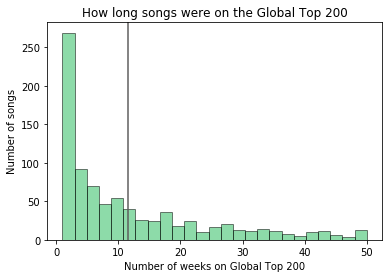

In [13]:
plt.hist(audio_features.song_count, bins=25, alpha=0.5,
          color='#1db954', edgecolor='black')
plt.xlabel("Number of weeks on Global Top 200")
plt.ylabel("Number of songs")
plt.title('How long songs were on the Global Top 200')
plt.axvline(x=audio_features.song_count.mean(), color='#5e5d5d')
plt.show()

As expected, the distribution for the number of weeks in 2017 a song charted is **right-skewed**; it's challenging to stay on the Global Top 200. Also note that the standard deviation (12.62) > mean (11.58). There must be something special about songs that stay on the charts beyond a certain length of time. Will the numbers reveal what that is?

In [14]:
audio_features[audio_features.song_count<=24].describe()[['acousticness', 'danceability', 'energy', 
                                                          'instrumentalness', 'liveness', 'speechiness','tempo', 
                                                          'valence', 'duration_min', 'Simran', 'Sohom']].style

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_min,Simran,Sohom
count,712,712,712,712,712,712,712,712,712,712,712
mean,0.21665,0.664223,0.632324,0.00889712,0.180882,0.117793,120.119,0.461868,3.63144,0.564607,0.429775
std,0.247486,0.140297,0.186976,0.0614836,0.137756,0.113633,28.0296,0.22531,0.771978,0.496157,0.495392
min,0.000115,0.24,0.0279,0,0.0219,0.0243,46.718,0.0371,0.846,0,0
25%,0.032125,0.581,0.52075,0,0.0936,0.044475,97.7532,0.2785,3.19,0,0
50%,0.111,0.674,0.657,0,0.125,0.0694,119.983,0.451,3.6025,1,0
75%,0.319,0.761,0.771,2.4625e-05,0.231,0.152,139.778,0.63625,3.99325,1,1
max,0.994,0.957,0.978,0.809,0.914,0.954,203.862,0.971,8.773,1,1


We chose 24 as our boundary as it is approximately one standard deviation above the mean. The table above shows numeric variables' summary statistics for songs that charted for **24 or fewer** weeks.

In [15]:
audio_features[audio_features.song_count>24].describe()[['acousticness', 'danceability', 'energy', 
                                                          'instrumentalness', 'liveness', 'speechiness','tempo', 
                                                          'valence', 'duration_min', 'Simran', 'Sohom']].style

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,duration_min,Simran,Sohom
count,143,143,143,143,143,143,143,143,143,143,143
mean,0.173432,0.702175,0.666881,0.00444853,0.158379,0.111127,118.597,0.530749,3.68127,0.706294,0.818182
std,0.179654,0.114137,0.144814,0.0241109,0.0937908,0.100538,28.5533,0.21759,0.562464,0.45706,0.38705
min,0.000282,0.314,0.314,0,0.0494,0.0232,74.989,0.0689,2.756,0,0
25%,0.03345,0.633,0.565,0,0.09435,0.04735,97.9825,0.386,3.354,0,1
50%,0.108,0.708,0.669,0,0.125,0.0649,107.989,0.527,3.557,1,1
75%,0.2425,0.7775,0.7945,1.37e-05,0.186,0.1325,139.468,0.708,3.856,1,1
max,0.835,0.927,0.962,0.21,0.565,0.449,199.864,0.966,5.719,1,1


The table above shows numeric variables' summary statistics for songs that charted for **more than 24** weeks. Certain features show fairly different summary statistic values in the two tables; songs that chart longer are less acoustic, lower on liveness, slightly lower in tempo and longer in duration on average. But the most important differentiators were **energy, danceability and valence**.

Before we move on to a more detailed analysis of those features, we want to point out that Sohom liked **almost 82%** of the songs that charted longer than 24 weeks, while he liked only 43% of those that charted for shorter times. While intuitively, it makes sense he'd like more of the overall most successful songs, his split is quite drastic. For comparison, Simran also liked a large percentage of songs that charted longer than 24 weeks – 71% – but she also liked 56% of those that did not. 

Below, we plot histograms for our three standout features.

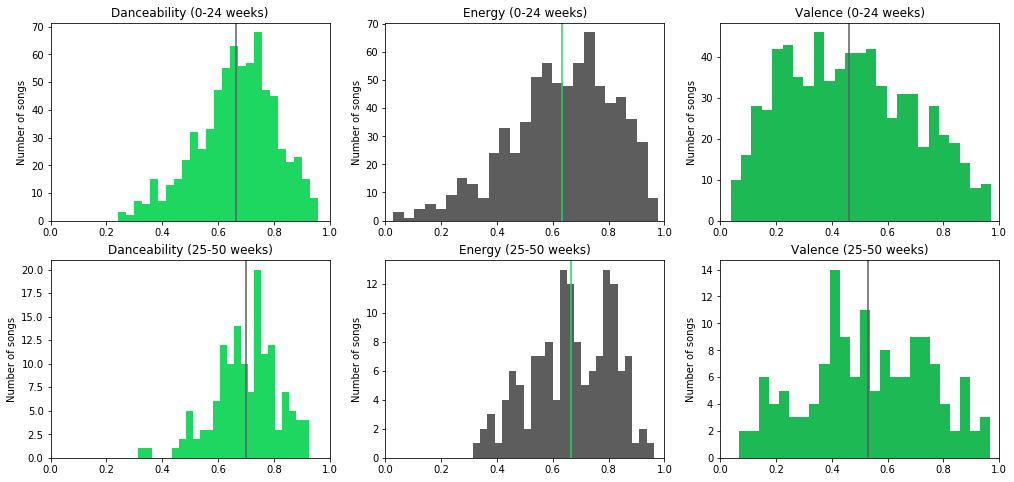

In [16]:
# Rhythm-related = 'danceability', 'energy', 'valence'
plt.figure(figsize=(17,8))
plt.tight_layout()

plt.subplot(2,3,1)
plt.hist('danceability', data=audio_features[audio_features.song_count<=24], bins=25, color="#1ed760")
plt.xlim(0.0,1.0)
plt.ylabel("Number of songs")
plt.title('Danceability (0-24 weeks)')
plt.axvline(x=audio_features[audio_features.song_count<=24].danceability.mean(), color='#5e5d5d')

plt.subplot(2,3,4)
plt.hist('danceability', data=audio_features[audio_features.song_count>24], bins=25, color="#1ed760")
plt.ylabel("Number of songs")
plt.title('Danceability (25-50 weeks)')
plt.axvline(x=audio_features[audio_features.song_count>24].danceability.mean(), color='#5e5d5d')
plt.xlim(0.0,1.0)

plt.subplot(2,3,2)
plt.hist('energy', data=audio_features[audio_features.song_count<=24], bins=25, color="#5e5d5d")
plt.ylabel("Number of songs")
plt.title('Energy (0-24 weeks)')
plt.axvline(x=audio_features[audio_features.song_count<=24].energy.mean(), color="#1ed760")
plt.xlim(0.0,1.0)

plt.subplot(2,3,5)
plt.hist('energy', data=audio_features[audio_features.song_count>24], bins=25, color="#5e5d5d")
plt.ylabel("Number of songs")
plt.title('Energy (25-50 weeks)')
plt.axvline(x=audio_features[audio_features.song_count>24].energy.mean(), color="#1ed760")
plt.xlim(0.0,1.0)

plt.subplot(2,3,3)
plt.hist('valence', data=audio_features[audio_features.song_count<=24], bins=25, color="#1db954")
plt.ylabel("Number of songs")
plt.title('Valence (0-24 weeks)')
plt.axvline(x=audio_features[audio_features.song_count<=24].valence.mean(), color='#5e5d5d')
plt.xlim(0.0,1.0)

plt.subplot(2,3,6)
plt.hist('valence', data=audio_features[audio_features.song_count>24], bins=25, color="#1db954")
plt.ylabel("Number of songs")
plt.title('Valence (25-50 weeks)')
plt.axvline(x=audio_features[audio_features.song_count>24].valence.mean(), color='#5e5d5d')
plt.xlim(0.0,1.0)

plt.show()

On average, songs that spent more than 24 weeks on the chart are much **higher on valence**, the measure of a song's musical sentiment. This makes sense, since people probably prefer to repetitively play music that makes them happy, even if they do enjoy sad, mellow music. 

These tracks are also to an extent **higher on danceability and energy**. To us, these features appear to be measures associated with catchiness, the somewhat numerically indefinable quality that keeps people listening to a song. (I'm willing to bet Spotify will manage to create a 'catchiness' feature in the near future.)

#### The absolute chartbusters:

These songs charted in all 50 weeks for which we obtained data. An aside: Ed Sheeran's immensely popular "Shape of You", which holds the record for most Spotify streams overall with just over 2 billion, missed out on this list as a result of being released the second week of January 2017. (It's still on the Global Top 200 this week, at #99. It's been almost two years.)

In [17]:
x = audio_features.song[audio_features.song_count==50]
y = audio_features.artist[audio_features.song_count==50]
z = audio_features.song_count[audio_features.song_count==50]
pd.concat([x, y, z], axis=1)

,song,artist,song_count
0,Starboy,The Weeknd,50.0
1,Closer,The Chainsmokers,50.0
4,I Don’t Wanna Live Forever (Fifty Shades Darke...,ZAYN,50.0
7,Say You Won't Let Go,James Arthur,50.0
11,One Dance,Drake,50.0
101,Photograph,Ed Sheeran,50.0
116,Redbone,Childish Gambino,50.0
118,Thinking Out Loud,Ed Sheeran,50.0
150,That's What I Like,Bruno Mars,50.0
190,goosebumps,Travis Scott,50.0


#### Further exploring duration_min, the length of a song:

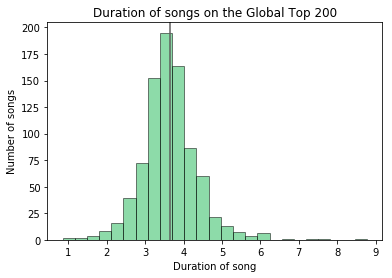

In [18]:
plt.hist(audio_features.duration_min, bins=25, alpha=0.5,
          color='#1db954', edgecolor='black')
plt.xlabel("Duration of song")
plt.ylabel("Number of songs")
plt.title('Duration of songs on the Global Top 200')
plt.axvline(x=audio_features.duration_min.mean(), color='#5e5d5d')
plt.show()

The distribution of song duration in minutes is approximately normal in shape. This is expected, as songs, especially those that chart, tend to be in the 3:30- to 4:30- minute range. We also thought it'd be fun to check out our outliers, considering they beat quite the odds to chart.

In [19]:
x = audio_features[audio_features.duration_min==audio_features.duration_min.min()][['song', 'artist','duration_min']]
y = audio_features[audio_features.duration_min==audio_features.duration_min.max()][['song', 'artist','duration_min']]
display(pd.concat([x,y]))

,song,artist,duration_min
646,The Explanation,XXXTENTACION,0.846
208,Give Me Love,Ed Sheeran,8.773


We were fairly surprised that a song that's 8 minutes and 46 seconds long made it to the Global Top 200; a song that came out in 2011, at that. We firmly believe Ed Sheeran is one of the few people it's possible to listen to multiple times for 8+ minutes straight.

The shortest song, "The Explanation", isn't just an outlier in this area; it also has the highest speechiness. It's an explanatory spoken audio clip from XXXTENTACION to his fans. It opens his 2017 album '17', and it's actually pretty moving, perhaps more so in the wake of his death and even despite his multiple crimes.

In [20]:
audio_features[audio_features.speechiness==audio_features.speechiness.max()][['song', 'artist','speechiness']]

,song,artist,speechiness
646,The Explanation,XXXTENTACION,0.954


#### Further exploring distributions for danceability, energy and valence:

We decided to single out a few features that had a common theme running through them. Danceability, energy and tempo are all related to a song's rhythm or speed; also, we thought we'd have a pretty good idea of how our 1s and 0s distributed across these features.

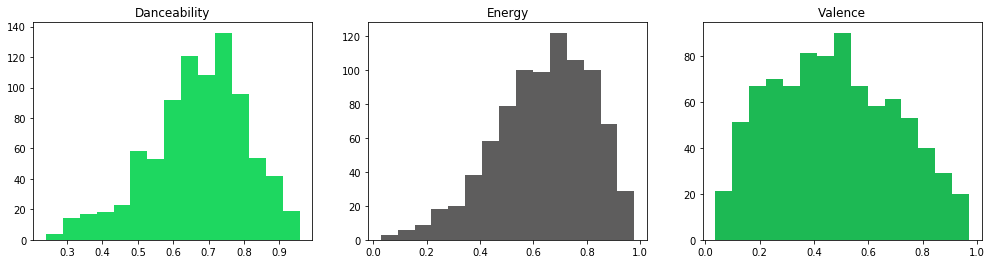

In [21]:
# Rhythm-related = 'danceability', 'energy', 'tempo.'
plt.figure(figsize=(17,4))
plt.tight_layout()
plt.subplot(1,3,1)
plt.hist('danceability', data=audio_features, bins=15, color="#1ed760")
plt.title('Danceability')
plt.subplot(1,3,2)
plt.hist('energy', data=audio_features, bins=15, color="#5e5d5d")
plt.title('Energy')
plt.subplot(1,3,3)
plt.hist('valence', data=audio_features, bins=15, color="#1db954")
plt.title('Valence')
plt.show()

Songs in the Global Top 200 display a particularly left skewed 'energy' distribution in comparison with the average distributions, shown below. The images below are taken from Spotify's API documentation on audio features. These distributions were most likely obtained by randomly sampling audio features for songs Spotify streams.

There also appears to be a 'magic' range, from about 0.72 to 0.78, for danceability; songs in this range charted far more frequently than those in any other. 

The distribution for valence has a similar mean to the average distribution, but contains fewer extremely happy and extremely sad songs.

<img src="https://developer.spotify.com/assets/audio/danceability.png" align="left" width="330" hspace="5"/> <img src="https://developer.spotify.com/assets/audio/energy.png" align = "left" width="330" hspace="5"/> <img src="https://developer.spotify.com/assets/audio/valence.png" align = "left" width="330"/> 

### Question #3: Moving on to us, how selective are we?

In [22]:
display(audio_features.Simran.value_counts().sort_values().to_frame())
display(audio_features.Sohom.value_counts().to_frame())

,Simran
0,352
1,503


,Sohom
0,432
1,423


**Simran**: It looks like Sohom is far more selective than I am. I'd like to interpret that as my being open to a wider range of things. (Rather than the alternative, which is that I don't have the highest standards.)

### Question #4: How are our likes and dislikes distributed across danceability, energy and valence?

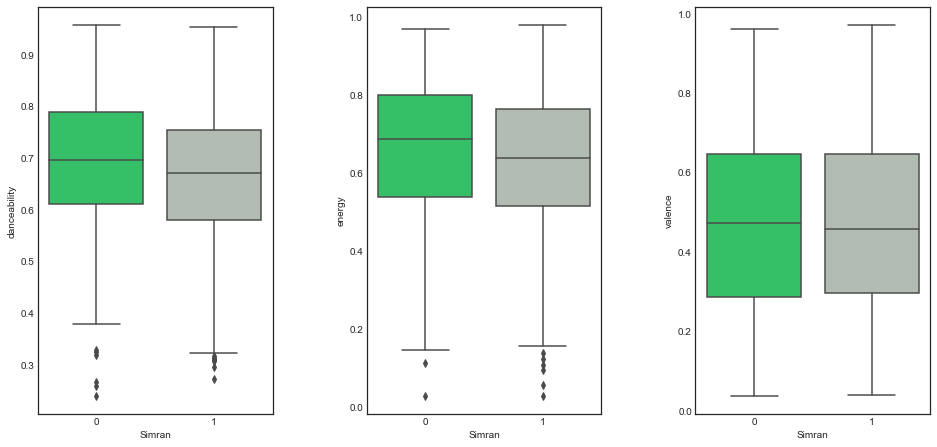

In [23]:
plt.figure(figsize=(16,7.5))
sns.set_style('white')
sns.despine
plt.subplots_adjust(wspace=0.4)
plt.subplot(1,3,1)
sns.boxplot("Simran", "danceability", data=audio_features, palette=["#1ed760","#b2bdb2"])
plt.subplot(1,3,2)
sns.boxplot("Simran", "energy", data=audio_features, palette=["#1ed760","#b2bdb2"])
plt.subplot(1,3,3)
sns.boxplot("Simran", "valence", data=audio_features, palette=["#1ed760","#b2bdb2"])
plt.show()

**Simran**: This doesn't surprise me; I tend to gravitate toward lower-energy, not particularly danceable music. I do like certain subgenres that can be high-energy and quite danceable, though, such as tropical house (Kygo exemplifies this genre) and indie pop. I would say I like an equal number of happy and sad songs, so the valence plot makes sense to me too.

However, none of these features clearly classify my tastes; there's quite a bit of overlap between the ranges my 0s and 1s cover. Hopefully we'll see some correlations with our scores when we build our model.

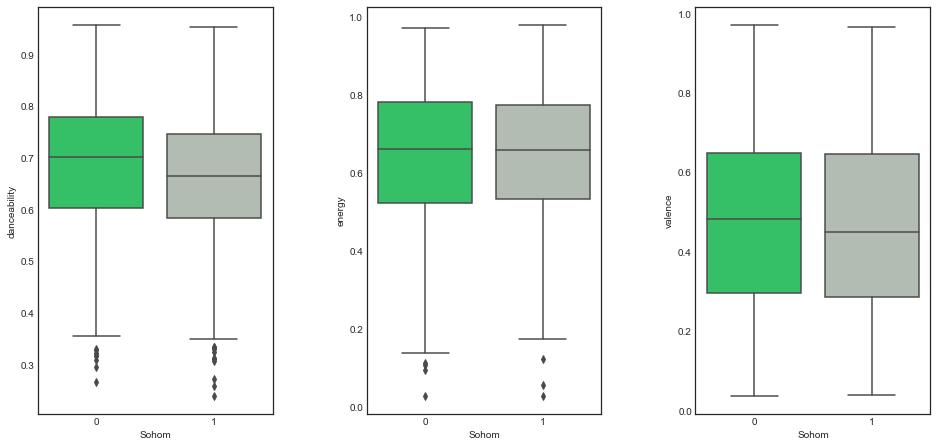

In [24]:
plt.figure(figsize=(16,7.5))
sns.set_style('white')
sns.despine
plt.subplots_adjust(wspace=0.4)
plt.subplot(1,3,1)
sns.boxplot("Sohom", "danceability", data=audio_features, palette=["#1ed760","#b2bdb2"])
plt.subplot(1,3,2)
sns.boxplot("Sohom", "energy", data=audio_features, palette=["#1ed760","#b2bdb2"])
plt.subplot(1,3,3)
sns.boxplot("Sohom", "valence", data=audio_features, palette=["#1ed760","#b2bdb2"])
plt.show()

**Sohom**: I found this pretty shocking. I've always loved happy songs with high danceability, so it's interesting that my 'disliked' songs had higher means across both metrics. One possible theory I have is that rap songs tend to have strong, stable rhythms and are quick in tempo (which factor into danceability), while reggaeton songs have both high danceability and energy. I'm not too fond of these genres, which may have led to these results. Nonetheless, this was a self-introspective moment for me!

### Question #5: How do we feel about chart darlings?

Next, we decided to take a look at how we each felt about the 15 artists who charted most in 2017. These were:

In [25]:
most = audio_features.artist.value_counts().head(20).to_frame()
most

,artist
Drake,28
Ed Sheeran,27
Eminem,20
Sam Smith,18
Linkin Park,17
The Chainsmokers,17
Kendrick Lamar,15
Lil Uzi Vert,14
The Weeknd,13
Big Sean,12


Most of these artists had an album release in 2017. In Taylor Swift's case, 2017 was the year she finally put her entire catalog on Spotify, which explains something we noticed: a lot of her charting tracks were not from 'reputation', her late-2017 release, but instead from '1989', her immensely successful 2014 pop album.

In [26]:
most_simran_liked = audio_features.loc[audio_features.artist.isin(most.index),].loc[audio_features['Simran'] == 1]
liked_simran = most_simran_liked.artist.value_counts().to_frame().reindex(most.index)
liked_simran = liked_simran.fillna(0)
disliked_simran = most['artist'] - liked_simran['artist']
for_plot_simran = pd.concat([liked_simran, disliked_simran], axis = 1)
for_plot_simran.columns = ['liked_simran', 'disliked_simran']

In [27]:
most_Sohom_liked = audio_features.loc[audio_features.artist.isin(most.index),].loc[audio_features['Sohom'] == 1]
liked_Sohom = most_Sohom_liked.artist.value_counts().to_frame().reindex(most.index)
liked_Sohom = liked_Sohom.fillna(0)
disliked_Sohom = most['artist'] - liked_Sohom['artist']
for_plot_Sohom = pd.concat([liked_Sohom, disliked_Sohom], axis = 1)
for_plot_Sohom.columns = ['liked_Sohom', 'disliked_Sohom']

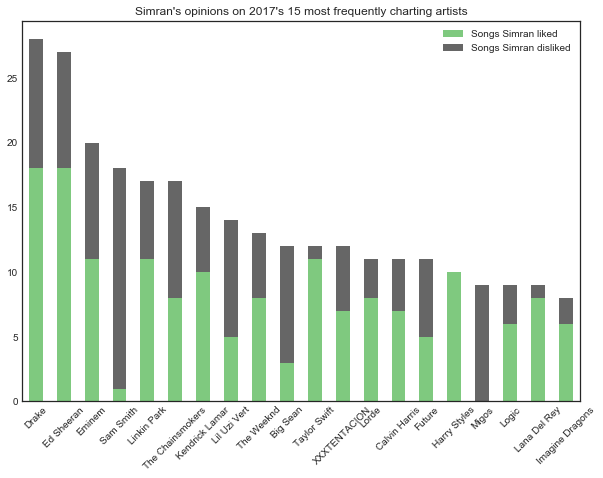

In [28]:
ax = for_plot_simran.plot(kind='bar', stacked = True, figsize=(10,7), colormap=cm.get_cmap('Accent', 2), 
                     rot=45, title="Simran's opinions on 2017's 15 most frequently charting artists")
ax.legend(["Songs Simran liked", "Songs Simran disliked"])
plt.show()

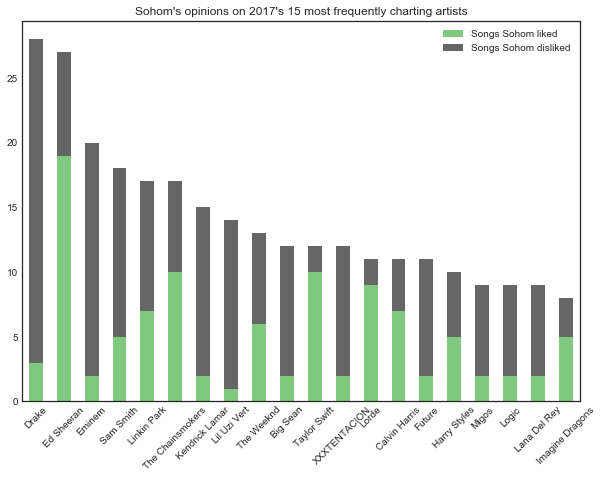

In [29]:
ax = for_plot_Sohom.plot(kind='bar', stacked = True, figsize=(10,7), colormap=cm.get_cmap('Accent', 2), 
                    rot=45, title="Sohom's opinions on 2017's 15 most frequently charting artists")
ax.legend(["Songs Sohom liked", "Songs Sohom disliked"])
plt.show()

Our plots for these artists reveal two quite different ways of consuming music. Simran's plot showed that her likes and dislikes were less dependent on artist, the only external piece of information we had besides song title during our listening sessions. Sohom tended to have defined opinions on certain artists to a larger extent than Simran.

Simran's favorite artists that charted multiple times in 2017, according to this plot, are Harry Styles, Taylor Swift and Lana Del Rey. (This is true.) Sohom's are Taylor Swift, Lorde and Imagine Dragons. He had very low proportions for likes for 10 artists, while Simran only really disliked three.

In [30]:
audio_features.artist.nunique()

328

Since we have 328 unique artists, we didn't think that would be a good predictor to use. We considered one-hot encoding, categorizing all artists besides the top 15 as "other", but we felt that the remaining artists, and how we felt about them, were too different to put into one single category.

### Question #5: Which numerical features appear correlated with our tastes?

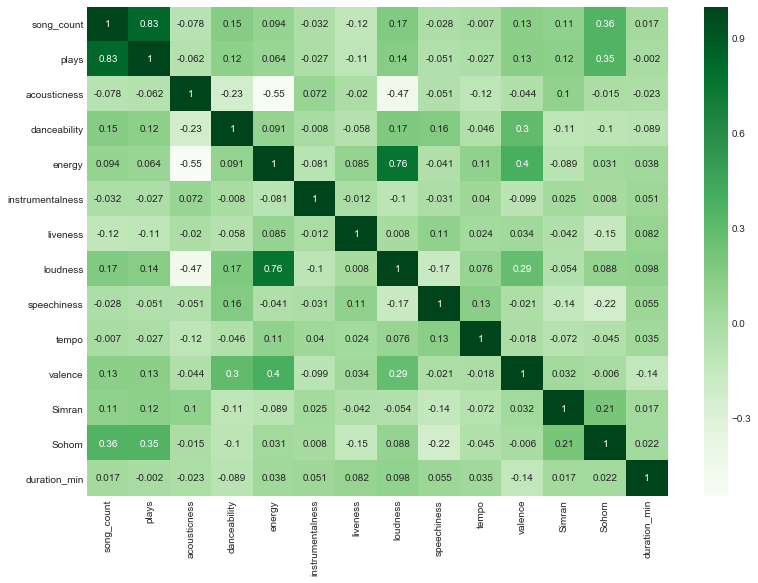

In [31]:
plt.figure(figsize=(13,9))
corr = np.round(audio_features.corr(), decimals=3)
sns.heatmap(corr, annot=True, cmap='Greens')
plt.show() # Personal referral vs. machine recommendation...

#### How the audio features were correlated with each other:

As expected, there is a high correlation between **song_count** (number of weeks a song is in the top 200) and **plays**. Songs that have the consistency to stay on top for many weeks aren't usually hyped up for a short duration, but rather are listened to over time.

There is also high correlation between loudness & energy, and fairly high ones between energy & valence, danceability & valence. These results are expected since these features are quite similar.

This correlation plot also effectively eliminated the need for scatterplots of our features, as they condense the results from each those into a concise square interpretable to those with statistical knowledge.

#### How each of our scores related to other variables in the data:

The correlation plot above was helpful since we learned a lot about the correlation between our song taste and key audio features. For instance, song count and plays are significant to Sohom's taste across songs, as is speechiness. 

In Simran's case, nothing was particularly highly correlated. This is probably because her music taste is less defined, as she likes multiple genres. 

We did not expect such a low correlation score, 0.21, between our taste variables. This project thus gave us numerical, broad insight into our music tastes compared with each other's as well.

Sohom's high correlation with song_count and plays, as well as their strong correlation to each other, inspired us to make scatterplots for the two features, with data points colored according to our opinions on them.

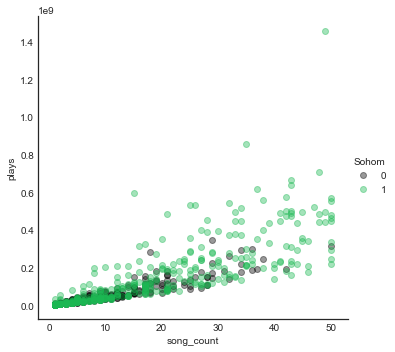

In [32]:
sns.lmplot('song_count', 'plays', hue='Sohom', data= audio_features, fit_reg=False, palette=["#000000","#1db954"], 
           scatter_kws={'alpha':0.4})
plt.show()

From the plot, it becomes evident that Sohom does not dislike any song that was played more than about 375 million times during its charting run, and likes almost every song that spent over 40 weeks on the charts.

As you can see below, it isn't quite as clear-cut for Simran.

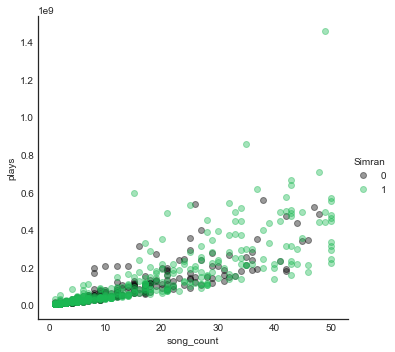

In [33]:
sns.lmplot('song_count', 'plays', hue='Simran', data= audio_features, fit_reg=False, palette=["#000000","#1db954"], 
           scatter_kws={'alpha':0.4})
plt.show()

## Data modeling

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

As we've mentioned earlier, we're using behavioral data, which tends to be less concrete and calculable than data designed a certain way. What we mean by this is that, as human beings, we do not consciously decide we like a song based on the metrics Spotify creates for it, or even any other object metric such as time signature or key, but rather on how it makes us feel. This makes predicting taste fundamentally different to predicting, say, pricing, which is strategically decided upon given certain factors.

This nuance, in addition to our fairly small amount of data (two listeners and about 850 songs), means we aren't expecting our classification models to work wonders, but instead to present rudimentary insight into the processes behind recommendation and personalizaton.

In [35]:
X = audio_features[['song_count', 'plays', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness',
                   'loudness', 'speechiness', 'tempo', 'valence', 'Simran', 'key', 'mode', 'duration_min', 
                    'time_signature']]
y = audio_features['Sohom']

In [36]:
forest = RandomForestClassifier()
forest.fit(X, y)
forest.feature_importances_

array([0.0982944 , 0.14277192, 0.06302655, 0.07709199, 0.05781971,
       0.03332769, 0.06523531, 0.06110872, 0.11473572, 0.06451792,
       0.07451832, 0.02195632, 0.03189133, 0.01332545, 0.07416573,
       0.00621294])

First, we fit a random forest model with Sohom's taste as the response, and all other features in the dataset, including my taste variable, as predictors. We then used this model to gauge the importance of each feature, and through this, picked the most important ones for our final model. Since plays and song_count are highly correlated, we elected to use only one of them, despite both being important.

This left us with **plays**, **liveness**, **speechiness** and **danceability**, as the rest of the features were comparatively less important.

In [37]:
X_selected = audio_features[['plays', 'loudness', 'speechiness', 'danceability']]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state=395)

In [39]:
forest = RandomForestClassifier(max_features='sqrt', max_depth=7, random_state= 103)
forest.fit(X_train, y_train)
y_forest = forest.predict(X_test)

print(confusion_matrix(y_test, y_forest))
print(accuracy_score(y_test, y_forest))

[[98 30]
 [54 75]]
0.6731517509727627


It's arguably more important for our prediction engine to have **fewer false positives**. Of course, we'd love to maximize our discoveries, but it's perhaps more important we aren't constantly recommended songs we don't like. 

The above model achieves this for Sohom: of the 105 songs it recommends Sohom from the charts we marked up with our likes and dislikes, he would like 75 of them i.e. 71%. He would miss out on 54 songs, though, which would be misclassified and therefore not recommended. (We set a random state for explanatory purposes, but our accuracy variously ranges from 64% to 70% on this model, with more of a tendency for false negatives than false positives.)

In [40]:
cv_scores = cross_val_score(forest, X_selected, y, cv=5)
print(np.mean(cv_scores))

0.6455012359901121


We cross-validated our model as well; it produces an accuracy of 64.5% with our current random state, and between 63% and 66% in general. This is likely a conservative estimate, so we rounded this figure up to 66% in our presentation for easy estimation. We also did not go into false negatives and positives on our presentation, as we did not want to lose momentum by dwelling on mathematical details.

In [41]:
X = audio_features[['song_count', 'plays', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness',
                   'loudness', 'speechiness', 'tempo', 'valence', 'Sohom', 'key', 'mode', 'duration_min']]
y = audio_features['Simran']

In [42]:
forest = RandomForestClassifier()
forest.fit(X, y)
forest.feature_importances_

array([0.05141979, 0.08794187, 0.07409591, 0.0909833 , 0.07587883,
       0.03293753, 0.09558378, 0.07184592, 0.09563996, 0.07343217,
       0.09608301, 0.02421556, 0.04970718, 0.01053944, 0.06969577])

Selecting features for Simran was more difficult, as there was no metric that explained her taste well. 

In [43]:
X_selected = audio_features[['speechiness', 'Sohom', 'danceability', 'energy']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state=395)

In [45]:
forest = RandomForestClassifier(max_features='sqrt', min_samples_split=55, max_depth=8, random_state=345)
forest.fit(X_train, y_train)
y_forest = forest.predict(X_test)

print(confusion_matrix(y_test, y_forest))
print(accuracy_score(y_test, y_forest))

[[ 39  70]
 [ 32 116]]
0.603112840466926


After a few unsuccessful logistic regression and random forest models using purportedly important features (they tended to produce a ~58% accuracy, the same as simply predicting she would like every song; the models even did that a few times), we decided the best course of action to prevent an excess of false positives would be to choose all the audio features she reacted most negatively to, as well as Sohom's taste, since his selectiveness would likely regulate her lack of the same. This gave us the best random forest model for Simran; for every song it recommended her, she would generally like around 61% of them. This was not a great improvement on the 58% she would like anyway, but it's something.

The fact that Sohom's taste served to regulate her false positives goes to show that were we to compile a user database, as we promise Star Records in our presentation, we would likely use listener correlations as predictors as well. It's almost certain that Spotify's recommender system does this.

In [46]:
cv_scores = cross_val_score(forest, X_selected, y, cv=4)
print(np.mean(cv_scores))

0.615204466675442


Combined with our analyses of the features of top tracks, we believe our models, especially if trained on more data (i.e. more user likes/dislikes and more tracks), could genuinely be useful to companies like Star Records, which is looking to use data to improve their charting performance as well as gain insight into the customer segments their music appeals to. 

We would thereby get them over the technological barriers to entry for Spotify's data and parse this data into a form that is ready for consumption by music professionals, given our understanding of music. Thus, we'd be giving them information with which they can make decisions about how to appeal to a mass audience, or, if they prefer, how to further appeal to a niche they already seem to be satisfying to an extent.